In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imripy import merger_system as ms
from imripy import halo
from imripy import inspiral
import HaloFeedbackKavanagh as HFK
import time

In [2]:
# Basic spike properties
g_spike = 7./3.
m1 = 1e3*ms.solar_mass_to_pc
m2 = 1*ms.solar_mass_to_pc
rho_spike = 226.*ms.solar_mass_to_pc
r_spike = ( (3 - g_spike) * m1 / (2 * np.pi * rho_spike) * 0.2**(3.-g_spike) )**(1./3.)
D = 1e6
R0 = 1e-8

Eps_grid = np.geomspace(1e-13, 1e0, 1000)
from scipy.special import gamma
f_grid = rho_spike * g_spike*(g_spike-1.)/(2.*np.pi)**(3./2.) * (r_spike/m1)**g_spike * gamma(g_spike-1.)/gamma(g_spike-1./2.) * Eps_grid**(g_spike-3./2.)
potential = lambda r: m1/r

dh = halo.DynamicSS(Eps_grid, f_grid, potential)
sp = ms.SystemProp(m1, m2, dh, D)

dhKav = HFK.PowerLawSpike(M_BH=m1/ms.solar_mass_to_pc, M_NS=m2/ms.solar_mass_to_pc, gamma=g_spike, rho_sp=rho_spike/ms.solar_mass_to_pc)

r_grid = np.geomspace(sp.r_isco(), 50*R0, 1000)

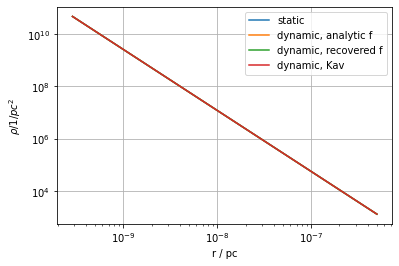

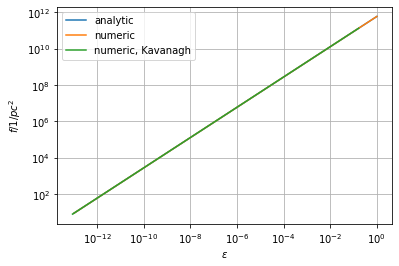

In [3]:
# Compute the phase space density from an initially static density profile and compare to analytic models
h = halo.Spike(rho_spike, r_spike, g_spike)
dh_rec = halo.DynamicSS.FromSpike(Eps_grid, sp, h)

plt.figure()
plt.loglog(r_grid, h.density(r_grid), label=r'static')
plt.loglog(r_grid, dh.density(r_grid), label='dynamic, analytic f')
plt.loglog(r_grid, dh_rec.density(r_grid), label='dynamic, recovered f')
plt.loglog(r_grid, [dhKav.rho(r)*ms.solar_mass_to_pc for r in r_grid], label='dynamic, Kav')
plt.xlabel('r / pc'); plt.ylabel(r'$\rho / 1/pc^2$')
plt.grid(); plt.legend()
plt.figure()
plt.loglog(Eps_grid, f_grid, label='analytic')
plt.loglog(dh_rec.Eps_grid, dh_rec.f_grid, label='numeric')
plt.loglog(dhKav.eps_grid/HFK.c**2, dhKav.f_eps*ms.solar_mass_to_pc*HFK.c**3 , label='numeric, Kavanagh')
plt.xlabel(r'$\varepsilon$'); plt.ylabel(r'$f / 1/pc^2$')
plt.grid(); plt.legend()
plt.show()

This:  0.0671
Kav:  0.0993


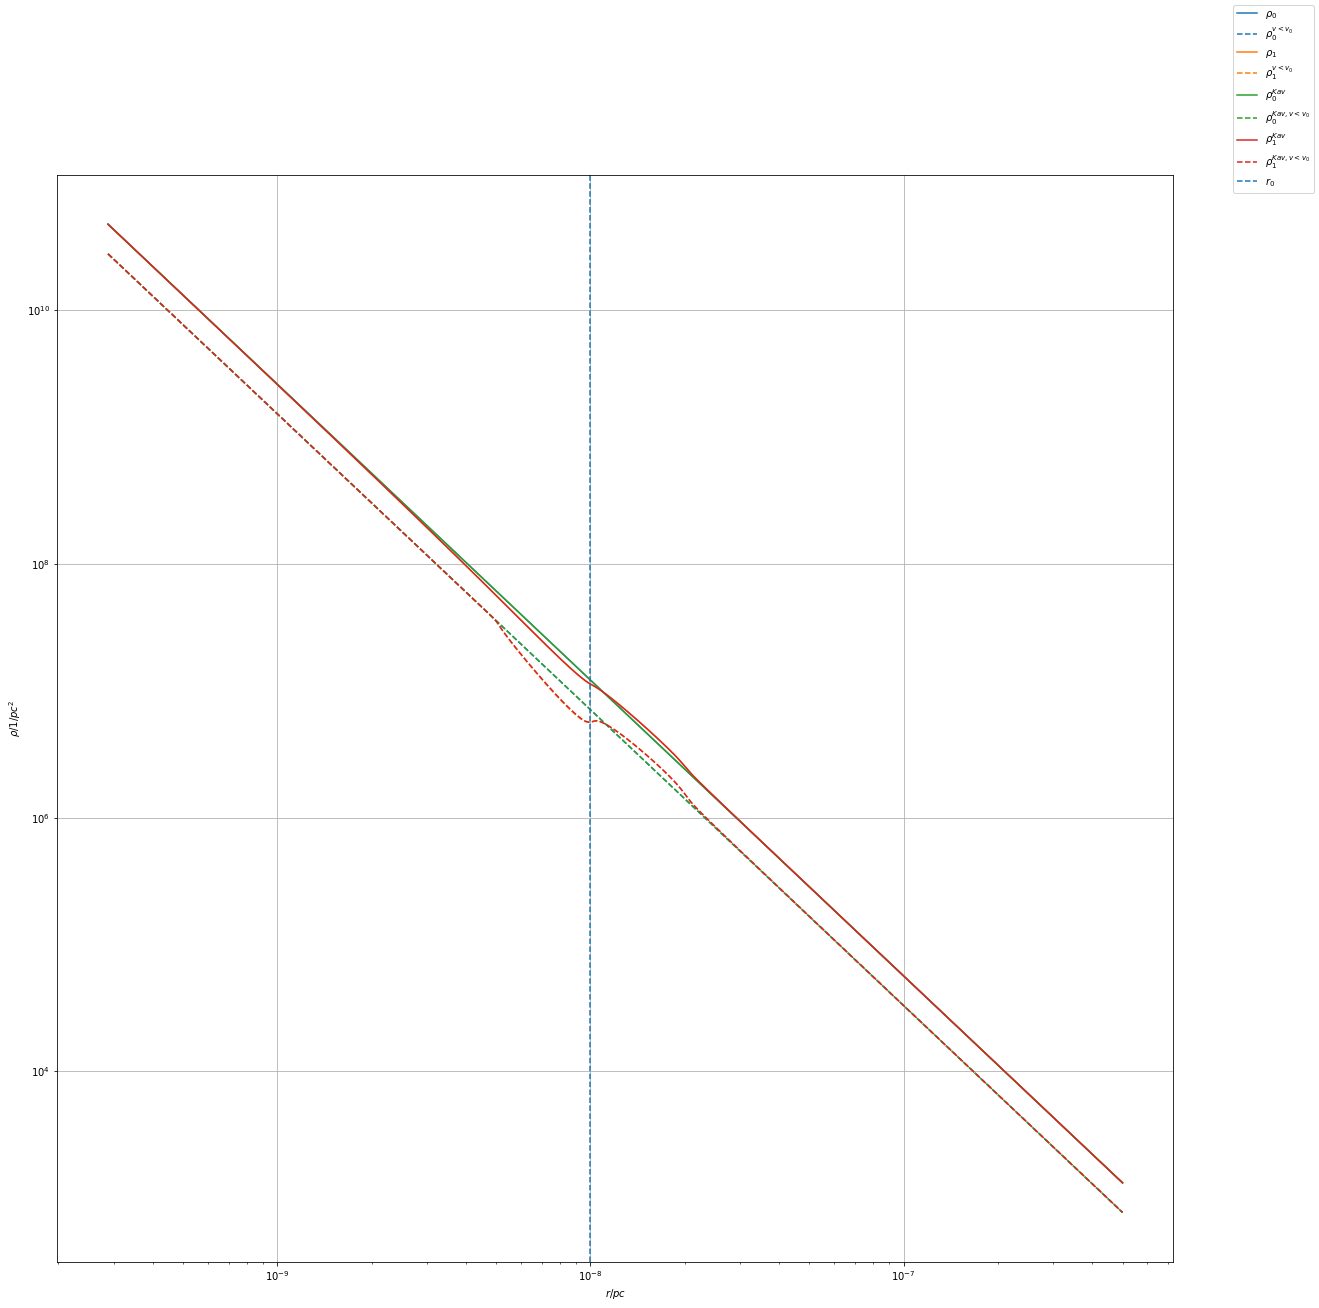

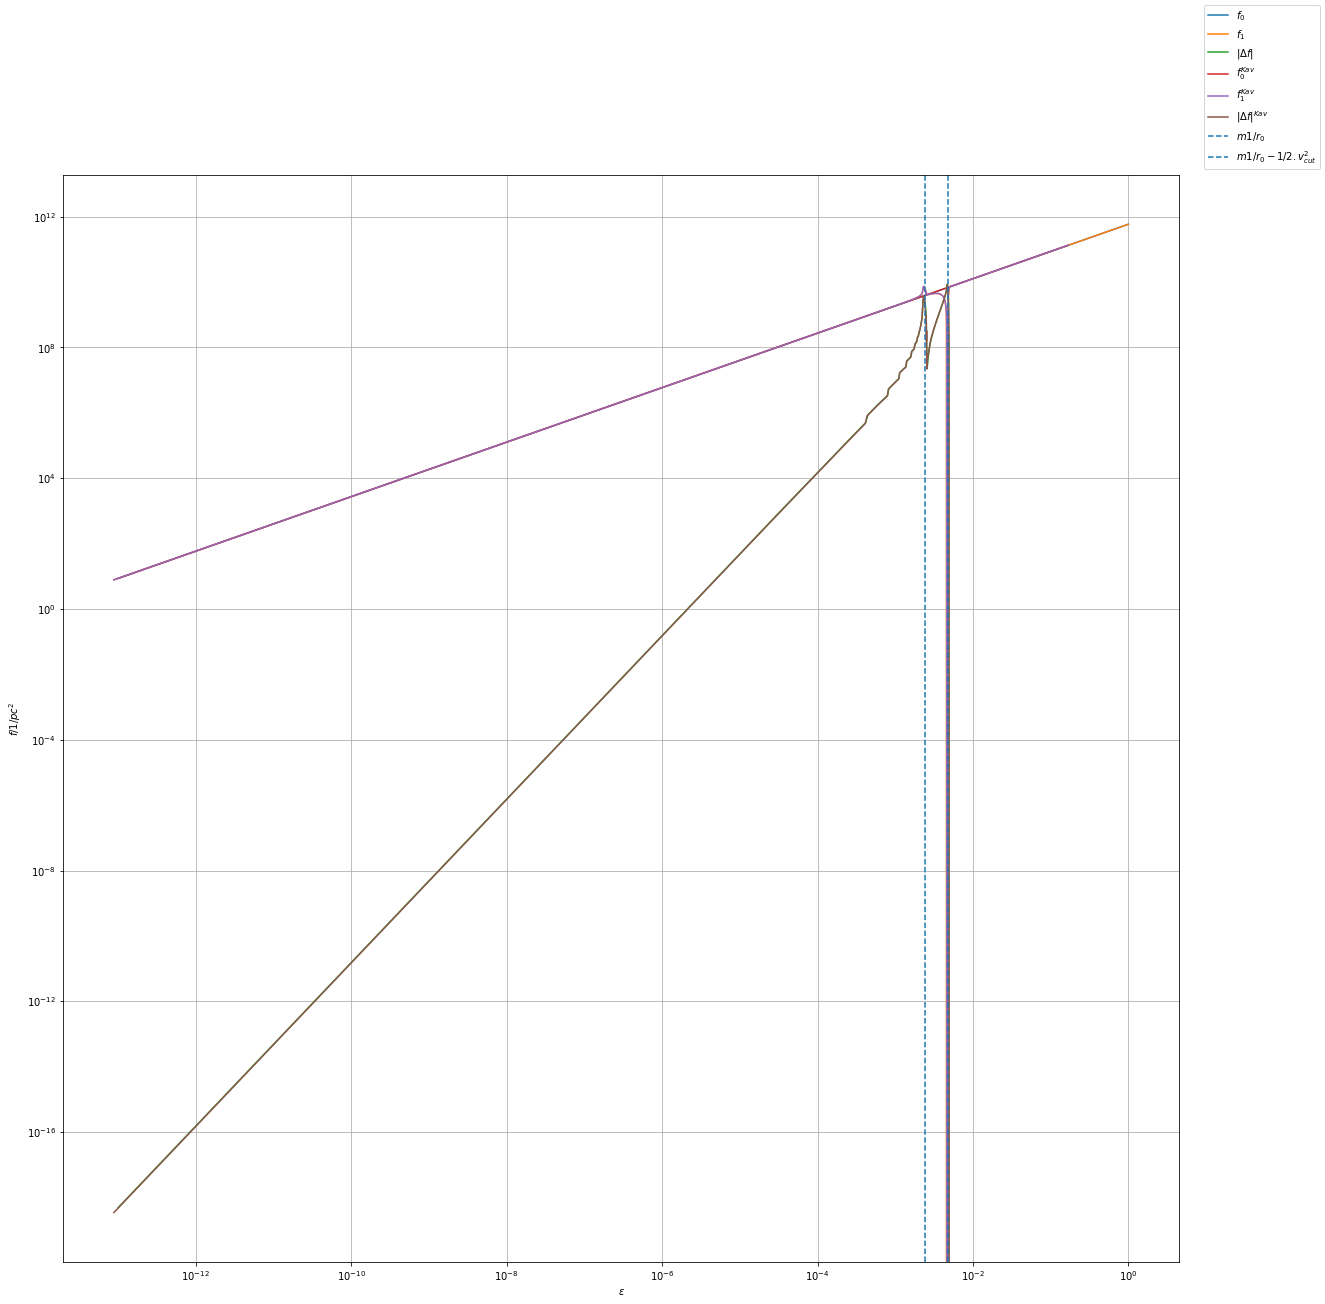

In [4]:
# Compare the derivatives of the phase space density
haloModel = inspiral.HaloFeedback(sp)

fig_rho = plt.figure(figsize=(20,20)); ax_rho = fig_rho.gca()
fig_f = plt.figure(figsize=(20,20)); ax_f = fig_f.gca()

# This code
ax_f.loglog(Eps_grid, dh.f_grid, label="$f_0$")
l, = ax_rho.loglog(r_grid, dh.density(r_grid), label=r'$\rho_0$')
ax_rho.loglog(r_grid, dh.density(r_grid, v_max=[sp.omega_s(r)*r for r in r_grid]),
                      color=l.get_c(), linestyle='--', label=r'$\rho_0^{v<v_0}$')

T_orb = 2.*np.pi / sp.omega_s(R0)
v_0 = R0* sp.omega_s(R0)
deltaT= 5e3 * T_orb

tic = time.perf_counter()
df_dt = haloModel.dfHalo_dt(R0, v_cut=v_0)
#df_dt = haloModel.dfHalo_dt( R0, v_cut=v_0, t_scale=deltaT)
toc = time.perf_counter()
dh.f_grid +=  deltaT*df_dt
print(f"This: {toc-tic : 0.4f}")

ax_f.loglog(dh.Eps_grid, dh.f_grid, label="$f_1$")
ax_f.loglog(dh.Eps_grid, np.abs(deltaT*df_dt), label="$|\Delta f|$")
l, = ax_rho.loglog(r_grid, dh.density(r_grid), label=r'$\rho_1$')
ax_rho.loglog(r_grid, dh.density(r_grid, v_max=[sp.omega_s(r)*r for r in r_grid]), 
                      color=l.get_c(), linestyle='--', label=r'$\rho_1^{v<v_0}$')

# Kavanagh et al
ax_f.loglog(dhKav.eps_grid/HFK.c**2, dhKav.f_eps*ms.solar_mass_to_pc*HFK.c**3 , label="$f_0^{Kav}$")
l, = ax_rho.loglog(r_grid, np.array([dhKav.rho(r) for r in r_grid])*ms.solar_mass_to_pc, label=r'$\rho_0^{Kav}$')
ax_rho.loglog(r_grid, np.array([dhKav.rho(r, sp.omega_s(r)*r * HFK.c) for r in r_grid])*ms.solar_mass_to_pc,
                          color=l.get_c(), linestyle='--', label=r'$\rho_0^{Kav, v<v_0}$')

v_0 = R0* sp.omega_s(R0)* HFK.c
T_orb = (2 * np.pi * R0 * HFK.pc_to_km) / v_0
deltaT= 5e3 * T_orb

tic = time.perf_counter()
df_dt = dhKav.dfdt(R0, v_0, v_cut=v_0)
#df_dt = dhKav.delta_f(R0, v_0, deltaT, v_cut=v_0)/deltaT
toc = time.perf_counter()
dhKav.f_eps +=  deltaT*df_dt
print(f"Kav: {toc-tic : 0.4f}")

ax_f.loglog(dhKav.eps_grid/HFK.c**2, dhKav.f_eps*ms.solar_mass_to_pc*HFK.c**3, label="$f_1^{Kav}$")
ax_f.loglog(dhKav.eps_grid/HFK.c**2, np.abs(deltaT*df_dt)*ms.solar_mass_to_pc*HFK.c**3, label="$|\Delta f|^{Kav}$")
l, = ax_rho.loglog(r_grid, np.array([dhKav.rho(r) for r in r_grid])*ms.solar_mass_to_pc, label=r'$\rho_1^{Kav}$')
ax_rho.loglog(r_grid, np.array([dhKav.rho(r, sp.omega_s(r)*r * HFK.c) for r in r_grid])*ms.solar_mass_to_pc,
                      color=l.get_c(), linestyle='--', label=r'$\rho_1^{Kav, v<v_0}$')

# other
ax_f.axvline(sp.m1/R0, linestyle='--', label='$m1/r_0$')
ax_f.axvline(sp.m1/R0 - 0.5 * (v_0/HFK.c)**2, linestyle='--', label='$m1/r_0 - 1/2. v^2_{cut}$')
ax_rho.axvline(R0, linestyle='--', label='$r_0$')

ax_rho.set_xlabel(r'$r / pc$'); ax_rho.set_ylabel(r'$\rho / 1/pc^2$')
ax_f.set_xlabel(r'$\varepsilon$'); ax_f.set_ylabel(r'$f / 1/pc^2$')
fig_rho.legend(); fig_f.legend()
ax_rho.grid(); ax_f.grid()

In [5]:
R0 = 50.* sp.r_isco()

Eps_grid = np.geomspace(1e-13, 1e0, 1000)
Eps_grid = np.sort(np.append(Eps_grid, np.geomspace(1e-1 * (sp.m1/R0 - (sp.omega_s(R0)*R0)**2 / 2.), 1e1 * sp.m1/R0, 2000)))

sp.halo.Eps_grid = Eps_grid; sp.halo.update_Eps()
haloModel = inspiral.HaloFeedback(sp)

In [6]:
def evolve(sp, R_0, t_fin):
    v_0 = sp.omega_s(R_0)*R_0
    T_orb =  2 * np.pi * R_0  / v_0

    dt_Torb = 1e3
    N_step = int(t_fin/T_orb/dt_Torb)
    dt = dt_Torb *T_orb

    t_list = np.array([0.]);   t = 0.
    f_list = np.array([sp.halo.f_grid]);

    i = 0
    while i < N_step and t < t_fin:
        df1 = haloModel.dfHalo_dt(R_0, v_cut=v_0, t_scale=dt)*dt
        sp.halo.f_grid += df1; 
        df2 = haloModel.dfHalo_dt(R_0, v_cut=v_0, t_scale=dt)*dt
        sp.halo.f_grid += 0.5 * (df2-df1);  
        t += dt

        print(i, "t=",t, ",dt=", dt, ",f=" , sp.halo.f_grid)
        t_list = np.append(t_list, t+dt)
        f_list = np.concatenate((f_list, [sp.halo.f_grid]))
        i+= 1

    return t_list, f_list

f_grid =  rho_spike * g_spike*(g_spike-1.)/(2.*np.pi)**(3./2.) * (r_spike/m1)**g_spike * gamma(g_spike-1.)/gamma(g_spike-1./2.) * Eps_grid**(g_spike-3./2.)
sp.halo.f_grid = f_grid;

v_0 = sp.omega_s(R0)*R0
T_orb =  2 * np.pi * R0  / v_0

t1, f1 = evolve(sp, R0, 2.5e5*T_orb)

0 t= 0.001566339676554711 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
1 t= 0.003132679353109422 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
2 t= 0.004699019029664133 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
3 t= 0.006265358706218844 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
4 t= 0.007831698382773556 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
5 t= 0.009398038059328267 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
6 t= 0.010964377735882979 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334

54 t= 0.08614868221050911 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
55 t= 0.08771502188706383 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
56 t= 0.08928136156361854 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
57 t= 0.09084770124017326 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
58 t= 0.09241404091672797 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
59 t= 0.09398038059328269 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
60 t= 0.0955467202698374 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e

108 t= 0.1707310247444633 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
109 t= 0.172297364421018 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
110 t= 0.1738637040975727 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
111 t= 0.1754300437741274 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
112 t= 0.1769963834506821 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
113 t= 0.1785627231272368 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
114 t= 0.1801290628037915 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e

162 t= 0.25531336727841725 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
163 t= 0.256879706954972 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
164 t= 0.2584460466315267 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
165 t= 0.26001238630808143 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
166 t= 0.26157872598463616 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
167 t= 0.2631450656611909 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
168 t= 0.2647114053377456 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.814253

216 t= 0.3398957098123726 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
217 t= 0.34146204948892733 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
218 t= 0.34302838916548206 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
219 t= 0.3445947288420368 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
220 t= 0.3461610685185915 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
221 t= 0.34772740819514625 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.81425334e+00 9.03711287e+00 ... 5.57168211e+11
 5.71255648e+11 5.85699273e+11]
222 t= 0.349293747871701 ,dt= 0.001566339676554711 ,f= [8.59688963e+00 8.814253

In [7]:
def evolve_HFK(dhKav, R_0, t_fin):
    v_0 = np.sqrt(HFK.G_N * (dhKav.M_BH + dhKav.M_NS) / (R_0))
    T_orb =  2 * np.pi * R_0 * HFK.pc_to_km / v_0

    dt_Torb = 1e3
    N_step = int(t_fin/T_orb/dt_Torb)
    dt = dt_Torb *T_orb

    t_list = np.array([0.]);   t = 0.
    f_list = np.array([dhKav.f_eps]);

    i = 0
    while i < N_step and t < t_fin:
        df1 = dhKav.delta_f(R_0, v_0, dt, v_cut=v_0)
        dhKav.f_eps += df1; 
        df2 = dhKav.delta_f(R_0, v_0, dt, v_cut=v_0)
        dhKav.f_eps += 0.5 * (df2-df1);  
        t += dt

        print(i, "t=",t, ",dt=", dt, ",f=" , dhKav.f_eps)
        t_list = np.append(t_list, t+dt)
        f_list = np.concatenate((f_list, [dhKav.f_eps]))
        i+= 1

    return t_list, f_list

dhKav = HFK.PowerLawSpike(M_BH=m1/ms.solar_mass_to_pc, M_NS=m2/ms.solar_mass_to_pc, gamma=g_spike, rho_sp=rho_spike/ms.solar_mass_to_pc)

v_0 = np.sqrt(HFK.G_N * (dhKav.M_BH + dhKav.M_NS) / (R0))
T_orb =  2 * np.pi * R0 * HFK.pc_to_km  / v_0
dt = 1e3 *T_orb

t2, f2 = evolve_HFK(dhKav, R0, 2.5e5 * T_orb)

0 t= 161440.36579608504 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
1 t= 322880.7315921701 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
2 t= 484321.0973882551 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
3 t= 645761.4631843402 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
4 t= 807201.8289804251 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
5 t= 968642.1947765101 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
6 t= 1130082.560572595 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213

56 t= 9202100.85037686 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
57 t= 9363541.216172945 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
58 t= 9524981.58196903 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
59 t= 9686421.947765116 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
60 t= 9847862.313561201 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
61 t= 10009302.679357287 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
62 t= 10170743.045153372 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18

112 t= 18242761.334957644 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
113 t= 18404201.70075373 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
114 t= 18565642.066549815 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
115 t= 18727082.4323459 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
116 t= 18888522.798141986 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
117 t= 19049963.16393807 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
118 t= 19211403.529734157 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+0

168 t= 27283421.81953843 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
169 t= 27444862.185334515 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
170 t= 27606302.5511306 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
171 t= 27767742.916926686 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
172 t= 27929183.28272277 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
173 t= 28090623.648518857 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
174 t= 28252064.014314942 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+0

224 t= 36324082.30411915 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
225 t= 36485522.66991523 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
226 t= 36646963.03571131 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
227 t= 36808403.40150739 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
228 t= 36969843.767303474 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
229 t= 37131284.133099556 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08 ... 6.18847213e-03
 6.10262665e-03 6.01797202e-03]
230 t= 37292724.49889564 ,dt= 161440.36579608504 ,f= [1.02397406e+08 1.02288296e+08 1.02179301e+08

250
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


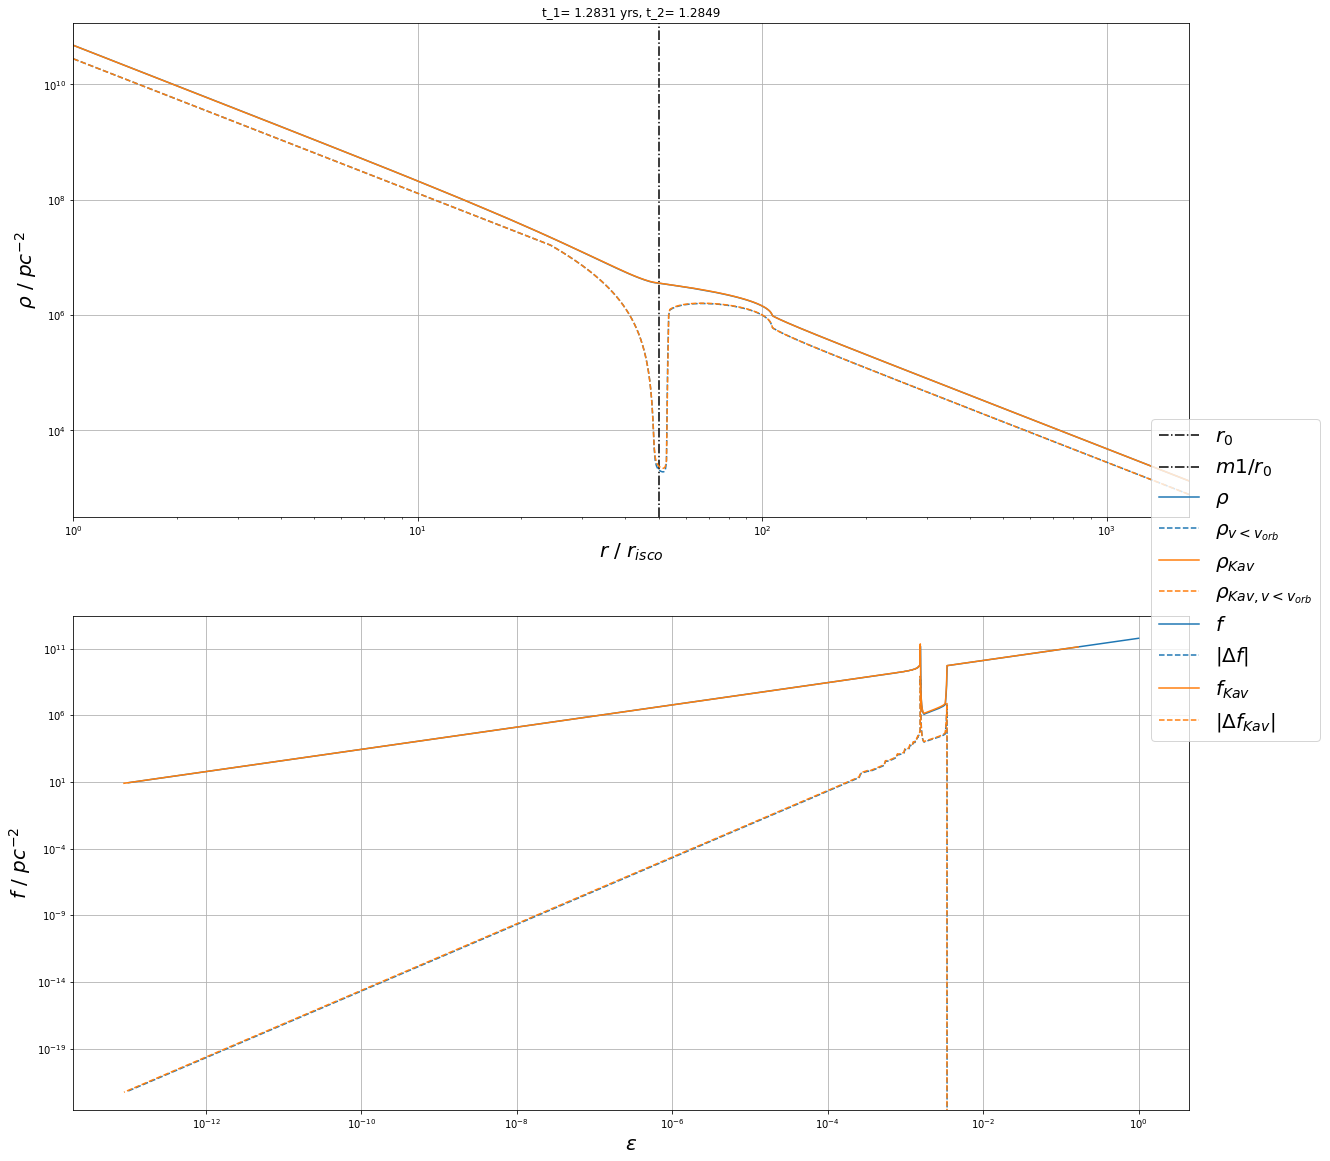

In [10]:
from matplotlib.animation import FuncAnimation
n_frame = max(len(t1), len(t2)) - 1
#n_frame = 10

print(n_frame)
fig, (ax_rho, ax_f) = plt.subplots(2, 1, figsize=(20,20))

index1 = 0; index2 = 0

v_0 = sp.omega_s(R0)*R0
Tini_orb =  2.*np.pi / sp.omega_s(R0)
lr0 = ax_rho.axvline(R0/sp.r_isco(), linestyle='-.', label='$r_0$', color='black')
lmr0 = ax_rho.axvline(sp.m1/R0, linestyle='-.', color=lr0.get_c(), label='$m1/r_0$')

dh.f_grid = f1[0,:]
lrho, = ax_rho.loglog(r_grid/sp.r_isco(), dh.density(r_grid), label=r'$\rho$')
lrho_v0, = ax_rho.loglog(r_grid/sp.r_isco(), dh.density(r_grid, v_max=[sp.omega_s(r)*r for r in r_grid]), 
                                  color=lrho.get_c(), linestyle='--', label=r'$\rho_{v<v_{orb}}$')


lf, = ax_f.loglog(dh.Eps_grid, dh.f_grid, label="$f$", color=lrho.get_c())

ldf, = ax_f.loglog(dh.Eps_grid, np.abs(haloModel.dfHalo_dt(R0, v_cut=v_0)*Tini_orb), 
                                  linestyle='--', color=lrho.get_c(), label="$|\Delta f|$")

l1 = [lrho, lrho_v0, lf, ldf]

dhKav.f_eps = f2[0,:]
lrho2, = ax_rho.loglog(r_grid/sp.r_isco(), np.array([dhKav.rho(r) for r in r_grid])*ms.solar_mass_to_pc, label=r'$\rho_{Kav}$')
lrho2_v0, = ax_rho.loglog(r_grid/sp.r_isco(), np.array([dhKav.rho(r, v_cut=np.sqrt(HFK.G_N * (dhKav.M_BH + dhKav.M_NS) / r)) for r in r_grid])*ms.solar_mass_to_pc, 
                                   linestyle='--', color=lrho2.get_c(), label=r'$\rho_{Kav,v<v_{orb}}$')

v_0 = np.sqrt(HFK.G_N * (dhKav.M_BH + dhKav.M_NS) / (R0))
lf2, = ax_f.loglog(dhKav.eps_grid/HFK.c**2, dhKav.f_eps*ms.solar_mass_to_pc*HFK.c**3, color=lrho2.get_c(), label="$f_{Kav}$")
ldf2, = ax_f.loglog(dhKav.eps_grid/HFK.c**2, np.abs(dhKav.delta_f(R0, v_0, T_orb, v_cut=v_0))*ms.solar_mass_to_pc*HFK.c**3, 
                                   linestyle='--', color=lrho2.get_c(), label="$|\Delta f_{Kav}|$")

l2 = [lrho2, lrho2_v0, lf2, ldf2]


ax_rho.set_ylabel(r'$\rho$ / $pc^{-2}$', fontsize=20); ax_rho.set_xlabel(r'$r$ / $r_{isco}$', fontsize=20); ax_rho.grid()
ax_f.set_ylabel(r'$f$ / $pc^{-2}$',fontsize=20); ax_f.set_xlabel(r'$\epsilon$', fontsize=20); ax_f.grid()
ax_rho.set_xlim((r_grid[0]/sp.r_isco(), r_grid[-1]/sp.r_isco()))
fig.legend(fontsize=20, loc='center right')

def init_plot():
    return l1+l2

def update_plot(frame):
    print(frame)
    global index1, index2
    updt1 = False; updt2 = False
    if len(t1) > len(t2):
        index1 += 1; updt1 = True
        if t1[index1]*HFK.pc_to_km/HFK.c > t2[index2] and index2 < len(t2) - 1:
            index2 += 1; updt2 = True
    elif len(t1) < len(t2):
        index2 += 1; updt2 = True
        if t2[index2] > t1[index1]*HFK.pc_to_km/HFK.c and index1 < len(t1) - 1:
            index1 += 1; updt1 = True
    else:
        index1 += 1; updt1 = True
        index2 += 1; updt2 = True

    #print(frame, index1, t[index1], index2, t2[index2])
    ax_rho.set_title(f"t_1={t1[index1]/ms.year_to_pc : .4f} yrs, t_2={t2[index2]*3.171*1e-8 : .4f}")
   
    if updt1:
        lrho, lrho_v0, lf, ldf = l1
        dh.f_grid = f1[index1,:]; 
        lrho.set_data(r_grid/sp.r_isco(), dh.density(r_grid))
        lrho_v0.set_data(r_grid/sp.r_isco(), dh.density(r_grid, v_max=[sp.omega_s(r)*r for r in r_grid]))
        lf.set_data(dh.Eps_grid, dh.f_grid)
        
        if index1 < len(t1)-1:
            delta_t = t1[index1+1] - t1[index1]
            v_0 = sp.omega_s(R0)*R0
            ldf.set_data(dh.Eps_grid, np.abs(haloModel.dfHalo_dt(R0, v_cut=v_0, t_scale=delta_t)*delta_t))

    
    if updt2:
        lrho2, lrho2_v0, lf2, ldf2 = l2
        dhKav.f_eps = f2[index2, :]; 
        lrho2.set_data(r_grid/sp.r_isco(), np.array([dhKav.rho(r) for r in r_grid])*ms.solar_mass_to_pc)
        lrho2_v0.set_data(r_grid/sp.r_isco(), np.array([dhKav.rho(r, v_cut=np.sqrt(HFK.G_N * (dhKav.M_BH + dhKav.M_NS) / r)) for r in r_grid])*ms.solar_mass_to_pc)
        lf2.set_data(dhKav.eps_grid/HFK.c**2, dhKav.f_eps*ms.solar_mass_to_pc*HFK.c**3)

        if index2 < len(t2)-1:
            delta_t = t2[index2+1] - t2[index2]
            v_0 = np.sqrt(HFK.G_N * (dhKav.M_BH + dhKav.M_NS) / (R0))
            ldf2.set_data(dhKav.eps_grid/HFK.c**2, np.abs(dhKav.delta_f(R0, v_0, delta_t, v_cut=v_0))*ms.solar_mass_to_pc*HFK.c**3)
    
    if not updt1:
        return l2
    if not updt2: 
        return l1
    return l1 + l2


ani = FuncAnimation(fig, update_plot, frames=n_frame, blit=True, init_func=init_plot , interval=100, repeat=True)
ani.save("crosschecks2002.12811.mp4")
plt.show()